In [1]:
!pip3 install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.1 MB/s eta 0:00:00


In [2]:
from urllib.request import urlretrieve #download and save data
from zipfile import ZipFile #unzip the downloaded file
import os #rename
directory_name="data"

try:
  os.mkdir(directory_name)
  print(f"directory {directory_name} create successfully!")
except FileExistsError:
  print(f"directory {directory_name} already exists")
except Exception as e:
  print(f"An error occurred {e}")
def download_data():
  data_url="https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
  filename="./data/spam_collection.zip"

  urlretrieve(data_url,filename)

  with ZipFile(filename,'r') as f:
    f.extractall('./data')

  sms_='./data/SMSSpamCollection'
  os.rename(sms_,'./data/SMSSpamCollection.tsv')


download_data()



directory data create successfully!


In [3]:
import pandas as pd
file_="./data/SMSSpamCollection.tsv"
df=pd.read_csv(file_,sep="\t",header=None,names=["Label","text"])
print(df.head())
print(df["Label"].value_counts())

  Label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Label
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
def create_balanced_dataset(df):
  num_spam= df[df["Label"] == "spam"].shape[0]
  new_ham=df[df["Label"]=="ham"].sample(num_spam,random_state=42)

  balanced_df=pd.concat([new_ham,df[df["Label"]=="spam"]])

  return balanced_df

balanced_df=create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
balanced_df["Label"]=le.fit_transform(balanced_df["Label"])
print(le.inverse_transform([0,1]))

['ham' 'spam']


In [6]:
from sklearn.model_selection import train_test_split

_df,test_df=train_test_split(balanced_df,test_size=0.2)
train_df,valid_df=train_test_split(_df,test_size=0.1)

print(train_df.shape,valid_df.shape,test_df.shape)

(1075, 2) (120, 2) (299, 2)


In [7]:
train_df.to_csv("train.csv",index=None)
valid_df.to_csv("valid.csv",index=None)
test_df.to_csv("test.csv",index=None)

In [8]:
import tiktoken
tokenizer=tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>",allowed_special={"<|endoftext|>"}))

[50256]


`Dataset`:
- subclass this to define how data is accessed and preprocessed
- Encapsulates dataloading logic and preprocessing in a single object
- Key methods:
  - `__init__` : initializes the dataset, loads data, optionally preprocesses it
  - `__len__`: returns the total number of samples in the dataset
  - `__getitem__`: retrieves a single data samples(and its corresponding label) based on the index

`Dataloader`
- load data from `Dataset` in batches during training or inference
- Automatically applies transformations like padding for sequences of varying lengths (when used with a collate_fn).
- Can use multiple workers to load data in parallel for efficiency.

a="kabir"
print(a[:10])
no error, prints kabir

In [9]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self,csv_file,tokenizer,max_length=None,pad_token_id=50256):
    self.data=pd.read_csv(csv_file)
    #preprocess the data
    self.encoded_texts=[tokenizer.encode(text) for text in self.data["text"]]

    if max_length is None:
      self.max_length=self._longest_encoded_length()
    else:
      #max len is provided, then, truncate or pad seq to that len
      self.max_length=max_length
      self.encoded_texts=[
          encoded_text[:self.max_length] for encoded_text in self.encoded_texts
      ]

    self.encoded_texts=[encoded_text + [pad_token_id] * (self.max_length-len(encoded_text))for encoded_text in self.encoded_texts]


  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    encoded=self.encoded_texts[index]
    label=self.data.iloc[index]["Label"]

    return (
        torch.tensor(encoded, dtype=torch.long),
        torch.tensor(label, dtype=torch.long)
    )


  def _longest_encoded_length(self):
    max_length=0
    for encoded_text in self.encoded_texts:
        encoded_length = len(encoded_text)
        if encoded_length > max_length:
            max_length = encoded_length
    return max_length



In [10]:
train_dataset=SpamDataset(csv_file="train.csv",tokenizer=tokenizer)
val_dataset=SpamDataset(csv_file="valid.csv",tokenizer=tokenizer,max_length=train_dataset.max_length)
test_dataset=SpamDataset(csv_file="test.csv",tokenizer=tokenizer,max_length=train_dataset.max_length)

In [11]:
print(train_dataset._longest_encoded_length())
print(train_dataset.__len__())

120
1075


In [12]:

import os

# Get the number of CPU cores available
num_workers = os.cpu_count()
print(f'Number of CPU cores available: {num_workers}')

Number of CPU cores available: 2


In [13]:
#Dataloaders

from torch.utils.data import DataLoader

num_workers=0
batch_size=8 # each batch will have 8 examples
torch.manual_seed(42)

train_loader=DataLoader(dataset=train_dataset,
                        batch_size=8,
                        shuffle=True,
                        num_workers=0,
                        drop_last=True)

val_loader=DataLoader(dataset=val_dataset,
                        batch_size=8,
                        shuffle=False,
                        num_workers=0,
                        drop_last=False)

test_loader=DataLoader(dataset=test_dataset,
                        batch_size=8,
                        shuffle=False,
                        num_workers=0,
                        drop_last=False)



In [14]:
for input_batch, target_batch in train_loader:
  pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)


print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])
134
15
38


In [15]:
sent=tokenizer.encode("Hello, my dog is cute")
sent=torch.tensor(sent)

In [16]:
from transformers import GPT2Model

model = GPT2Model.from_pretrained("openai-community/gpt2")

output=model(sent)
print(output.last_hidden_state.size())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

torch.Size([6, 768])


In [17]:
model.config.hidden_size

768

In [18]:
from torch import nn
class GPT2forSpamClf(nn.Module):
  def __init__(self,num_labels=2,model_name="gpt2",freeze_base=True):
    super(GPT2forSpamClf,self).__init__()
    self.num_labels=num_labels

    self.gpt2=GPT2Model.from_pretrained("openai-community/gpt2")

    if freeze_base:
      for param in self.gpt2.parameters():
        param.requires_grad=False

    self.classifier=nn.Linear(self.gpt2.config.hidden_size, num_labels)

  def forward(self,input_ids):
    outputs=self.gpt2(input_ids)
    hidden_states=outputs.last_hidden_state #(batch_size, seq_len, hidden_size)
    logits=self.classifier(hidden_states[:,-1,:])
    return logits



In [19]:
gpt2=GPT2forSpamClf()

In [20]:
inputs=tokenizer.encode("i love dogs")
inputs=torch.tensor(inputs).unsqueeze(0)
probas=torch.softmax(gpt2(inputs),dim=-1)
label=torch.argmax(probas)
print(label)
print(label.item())

tensor(1)
1


In [21]:
def calculate_accuracy(data_loader,model,device, num_batches=None):
  #evaluation mode
  model.eval()
  correct_predictions=0
  num_examples=0

  if num_batches is None:
    num_batches=len(data_loader)
  else:
    num_batches=min(num_batches,len(data_loader))

  for i, (input_batch,target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch=input_batch.to(device)
      target_batch=target_batch.to(device)

      with torch.no_grad():
        logits=model(input_batch)

      predicted_labels=torch.argmax(logits,dim=-1)

      num_examples +=predicted_labels.shape[0]

      correct_predictions+=( (predicted_labels==target_batch).sum().item())
    else:
      break

  return correct_predictions/num_examples




In [22]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt2.to(device)

torch.manual_seed(42)
train_accuracy=calculate_accuracy(train_loader,gpt2,device,num_batches=10)
val_accuracy=calculate_accuracy(val_loader,gpt2,device,num_batches=10)
test_accuracy=calculate_accuracy(test_loader,gpt2,device,num_batches=10)

print(f"training acc",train_accuracy*100,'%')
print(f"val acc",val_accuracy*100,'%')
print(f"test_acc",test_accuracy*100,'%')

training acc 43.75 %
val acc 51.24999999999999 %
test_acc 51.24999999999999 %


In [23]:
def calculate_loss_batch(input_batch,target_batch,model,device):
  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)
  logits=model(input_batch)
  loss=torch.nn.functional.cross_entropy(logits,target_batch)
  return loss

In [24]:
def calculate_loss_loader(data_loader,model,device,num_batches=None):
  total_loss=0
  if len(data_loader)==0:
    return float("nan")

  elif num_batches is None:
    num_batches=len(data_loader)

  else:
    num_batches=min(num_batches,len(data_loader))

  for i,(input_batch,target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss=calculate_loss_batch(input_batch,target_batch,model,device)

      total_loss+=loss.item()
    else:
      break
  return total_loss / len(data_loader)

In [25]:
with torch.no_grad():
  train_loss=calculate_loss_loader(train_loader,gpt2,device,num_batches=5)

print(train_loss)

0.034483952308768655


In [26]:
def eval_model(model,train_loader,val_loader,device,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss=calculate_loss_loader(
        train_loader,model,device,num_batches=eval_iter
    )
    val_loss=calculate_loss_loader(
        val_loader,model,device,eval_iter
    )

  model.train()

  return train_loss,val_loss

In [27]:
def train_classifier(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter):
  train_losses,val_losses,train_accs,val_accs=[],[],[],[]

  examples_seen=0
  global_step=-1


  for epoch in range(num_epochs):

    model.train()


    for input_batch,target_batch in train_loader:
      loss=calculate_loss_batch(input_batch,target_batch,model,device)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      examples_seen+=input_batch.shape[0]
      global_step+=1

      if global_step%eval_freq==0:
        train_loss,val_loss=eval_model(model,train_loader,val_loader,device,eval_iter)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}, Step {global_step:06d}, Train_loss:{train_loss:.3f}, Val_loss:{val_loss:.3f}")


    train_accuracy=calculate_accuracy(train_loader,model,device,num_batches=eval_iter)
    val_accuracy=calculate_accuracy(val_loader,model,device,num_batches=eval_iter)
    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

  return train_losses, val_losses, train_accs, val_accs, examples_seen



In [29]:
import time

start_time=time.time()
torch.manual_seed(42)
optimizer=torch.optim.AdamW(gpt2.parameters(),lr=5e-5,weight_decay=0.1)
num_epochs=10

train_losses, val_losses, train_accs, val_accs, examples_seen=train_classifier(gpt2,train_loader,val_loader,optimizer,device,num_epochs,eval_freq=50,eval_iter=5)

end_time=time.time()

execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Epoch 1, Step 000000, Train_loss:0.026, Val_loss:0.224
Epoch 1, Step 000050, Train_loss:0.023, Val_loss:0.217
Epoch 1, Step 000100, Train_loss:0.024, Val_loss:0.217
Training accuracy: 67.50% | Validation accuracy: 62.50%
Epoch 2, Step 000150, Train_loss:0.024, Val_loss:0.217
Epoch 2, Step 000200, Train_loss:0.024, Val_loss:0.216
Epoch 2, Step 000250, Train_loss:0.023, Val_loss:0.215
Training accuracy: 80.00% | Validation accuracy: 75.00%
Epoch 3, Step 000300, Train_loss:0.023, Val_loss:0.213
Epoch 3, Step 000350, Train_loss:0.023, Val_loss:0.214
Epoch 3, Step 000400, Train_loss:0.022, Val_loss:0.213
Training accuracy: 72.50% | Validation accuracy: 75.00%
Epoch 4, Step 000450, Train_loss:0.023, Val_loss:0.212
Epoch 4, Step 000500, Train_loss:0.022, Val_loss:0.211
Training accuracy: 85.00% | Validation accuracy: 75.00%
Epoch 5, Step 000550, Train_loss:0.022, Val_loss:0.210
Epoch 5, Step 000600, Train_loss:0.022, Val_loss:0.208
Epoch 5, Step 000650, Train_loss:0.023, Val_loss:0.212
Traini

In [31]:
print(examples_seen,len(train_losses),len(val_losses),len(train_accs),len(val_accs))

10720 27 27 10 10


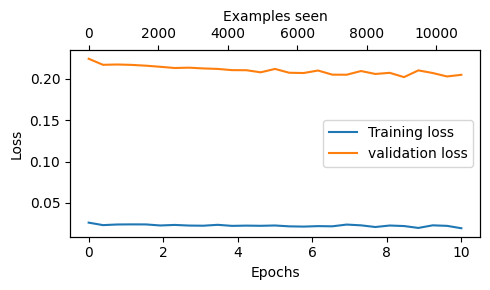

In [32]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen,examples_seen,train_values,val_values,label="loss"):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epochs_seen,train_values,label=f"Training {label}")
  ax1.plot(epochs_seen,val_values,label=f"validation {label}")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel(label.capitalize())
  ax1.legend()

  ax2=ax1.twiny()
  ax2.plot(examples_seen, train_values, alpha=0)
  ax2.set_xlabel("Examples seen")
  fig.tight_layout()
  plt.savefig(f"{label}-plot.pdf")
  plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)


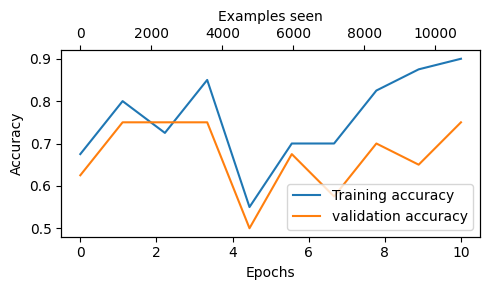

In [33]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

In [36]:
def classify_review(text,model,tokenizer,device,max_length=None,pad_token_id=50256):

  model.eval()

  input_ids=tokenizer.encode(text)
  input_ids=input_ids[:max_length]

  input_ids += [pad_token_id] * (max_length - len(input_ids))
  input_tensor = torch.tensor(
    input_ids, device=device
    ).unsqueeze(0)

  with torch.no_grad():
    logits = model(input_tensor)
  predicted_label = torch.argmax(logits, dim=-1).item()

  return "spam" if predicted_label == 1 else "not spam"




In [37]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
    text_1, gpt2, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [38]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, gpt2, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [40]:
torch.save(gpt2.state_dict(), "review_classifier.pth")

model_state_dict = torch.load("review_classifier.pth, map_location=device")  
model.load_state_dict(model_state_dict)